In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import warnings

from scipy.stats import kurtosis, skew

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

import shap

/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")
plt.style.use('tableau-colorblind10')

## Dataset

In [4]:
# Reading Train data
full_train_data = pl.read_csv("../data/merged_cleaned_insurance_data.csv")

In [5]:
full_train_data.head()

Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Claim_Duration,Admitted_Duration,AGE,Att_Opr_Oth_Phy_Tot_Claims,Prv_Tot_Att_Opr_Oth_Phys,PRV_Tot_Admit_DCodes,PRV_Tot_DGrpCodes,PRV_Tot_Unq_DOB_Years,PRV_Bene_Age_Sum,PRV_Insc_Clm_ReImb_Amt,PRV_Tot_RKD_Patients,PRV_IP_Annual_ReImb_Amt,PRV_IP_Annual_Ded_Amt,PRV_OP_Annual_ReImb_Amt,PRV_OP_Annual_Ded_Amt,PRV_Admit_Duration,PRV_Claim_Duration,BENE_Insc_ReImb_Amt,BENE_IP_Annual_ReImb_Amt,BENE_IP_Annual_Ded_Amt,BENE_OP_Annual_ReImb_Amt,BENE_OP_Annual_Ded_Amt,BENE_Admit_Duration,BENE_Claim_Duration,Claim_Admit_Diag_Code_Insc_ReImb_Amt,Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt,Claim_Admit_Diag_Code_IP_Annual_Ded_Amt,Claim_Admit_Diag_Code_OP_Annual_ReImb_Amt,Claim_Admit_Diag_Code_OP_Annual_Ded_Amt,Claim_Admit_Diag_Code_Admit_Duration,Claim_Admit_Diag_Code_Claim_Duration,ClmCount_Provider,ClmCount_Provider_BeneID,ClmCount_Provider_AttendingPhysician,ClmCount_Provider_BeneID_AttendingPhysician,ClmCount_Provider_ClmAdmitDiagnosisCode,Is_Alive?,Gender_1,Race_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive_No,Is_Alive_Yes
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""PRV55912""",26000,1068,0,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,1,6,6,67,802240,321,60,57,40,8141,750080,33,1420920,148908,249270,59690,388,469,36000,108000,9612,180,210,11,11,935850,2345220,216260,519910,164950,343,433,107,1,1,1,1,1,1,1,0,0,0,1,0,1
"""PRV55907""",5000,1068,0,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,0,2,2,67,358478,729,82,52,56,17866,598180,59,1946470,204920,608230,171700,346,660,36000,108000,9612,180,210,11,11,15000,46210,6408,6040,1070,5,5,243,1,2,1,1,1,1,1,0,0,0,1,0,1
"""PRV56046""",5000,1068,0,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,0,3,3,67,443774,60,16,15,15,1396,121680,1,366840,33632,24050,4730,72,72,36000,108000,9612,180,210,11,11,414380,1281180,166460,232690,70360,612,890,20,1,5,1,1,1,1,1,0,0,0,1,0,1
"""PRV52405""",5000,1068,0,0,1,1,0,0,1,1,0,0,1,1,5000,1068,250,320,0,8,8,95,41,267,40,23,41,6372,189070,23,656110,65148,251730,88310,88,273,5180,20000,4272,1000,1280,8,8,975790,1503930,151624,100350,34330,460,481,89,1,31,1,1,1,0,0,1,0,0,1,0,1
"""PRV56614""",10000,1068,1,0,1,1,0,1,1,0,1,0,0,0,21260,2136,120,100,0,17,17,71,358481,78,16,16,17,1883,126100,12,311840,33108,103960,28700,102,116,10060,42520,4272,240,200,17,17,202520,654490,67284,241040,75660,61,80,26,1,2,1,1,1,0,1,0,0,0,1,0,1


The goal of this step is to transform our raw claim-level data into provider-level aggregates, because the main objective of our project is to detect Medicare provider fraud and fraud typically happens at the provider level, not the individual claim level.

So what I did was group the dataset by 'Provider' and 'PotentialFraud', and then aggregate all other numerical columns using the sum function. This gives us a compact, n-dimensional representation of each provider, where each row corresponds to a provider and contains total values like total reimbursements, total number of procedures, total claim durations, and so on.

In [6]:
full_train_data = (
    full_train_data
    .group_by(["Provider", "PotentialFraud"])
    .agg([
        pl.col("*").exclude(["Provider", "PotentialFraud"]).sum()
    ])
)

In [7]:
print(f"full_train_data.shape: {full_train_data.shape}")

full_train_data.shape: (5410, 65)


### Train Test Split

In [8]:
X = full_train_data.drop(['Provider', 'PotentialFraud'])

y = full_train_data.select('PotentialFraud')

X_shape = X.shape
y_shape = y.shape
X_type = type(X)
y_type = type(y)

print(X_shape, X_type)
print(y_shape, y_type)

(5410, 63) <class 'polars.dataframe.frame.DataFrame'>
(5410, 1) <class 'polars.dataframe.frame.DataFrame'>


In [9]:
print(X.head())
print(y.head())

shape: (5, 63)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ InscClaimA ┆ Deductible ┆ RenalDise ┆ ChronicCo ┆ … ┆ Race_5 ┆ Admitted? ┆ Is_Alive_ ┆ Is_Alive_ │
│ mtReimburs ┆ AmtPaid    ┆ aseIndica ┆ nd_Alzhei ┆   ┆ ---    ┆ _1        ┆ No        ┆ Yes       │
│ ed         ┆ ---        ┆ tor       ┆ mer       ┆   ┆ i64    ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ i64        ┆ ---       ┆ ---       ┆   ┆        ┆ i64       ┆ i64       ┆ i64       │
│ i64        ┆            ┆ i64       ┆ i64       ┆   ┆        ┆           ┆           ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ 40000      ┆ 6408       ┆ 2         ┆ 3         ┆ … ┆ 0      ┆ 6         ┆ 0         ┆ 6         │
│ 1690       ┆ 0          ┆ 3         ┆ 7         ┆ … ┆ 0      ┆ 0         ┆ 0         ┆ 16        │
│ 4000       ┆ 2136       ┆ 0         ┆ 1         ┆ … ┆ 0      ┆ 2         ┆

In [10]:
X_pd = X.to_pandas()
y_pd = y.to_pandas().squeeze()

X_train, X_test, y_train, y_test = train_test_split(
    X_pd, y_pd,
    test_size=0.20,
    stratify=y_pd,
    random_state=39
)


print("SHAPES:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nTARGET DISTRIBUTION IN y_train:")
print(y_train.value_counts())

print("\nTARGET DISTRIBUTION IN y_test:")
print(y_test.value_counts())

SHAPES:
X_train: (4328, 63)
X_test: (1082, 63)
y_train: (4328,)
y_test: (1082,)

TARGET DISTRIBUTION IN y_train:
PotentialFraud
0    3923
1     405
Name: count, dtype: int64

TARGET DISTRIBUTION IN y_test:
PotentialFraud
0    981
1    101
Name: count, dtype: int64


### Scaling

In [11]:
robust_scaler = RobustScaler()
X_train_std = robust_scaler.fit_transform(X_train)
X_test_std = robust_scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)

In [12]:
counter = Counter(y_train)
print(f"Before SMOTE class distribution: {counter}")

fraud_percentage = (counter[1] * 100) / (counter[0] + counter[1])
non_fraud_percentage = (counter[0] * 100) / (counter[0] + counter[1])
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Before SMOTE class distribution: Counter({0: 3923, 1: 405})
Fraud Percentage = 9.36% and Non-Fraud Percentage = 90.64%


In [13]:
if fraud_percentage < 20:
    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
    X_train_ovsamp, y_train_ovsamp = smote.fit_resample(X_train_std, y_train)

    counter = Counter(y_train_ovsamp)
    print(f"After SMOTE class distribution: {counter}")

    fraud_percentage = (counter[1] * 100) / (counter[0] + counter[1])
    non_fraud_percentage = (counter[0] * 100) / (counter[0] + counter[1])
    print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))
else:
    print("SMOTE not applied because class imbalance is acceptable.")
    X_train_ovsamp, y_train_ovsamp = X_train_std, y_train

After SMOTE class distribution: Counter({0: 3923, 1: 3923})
Fraud Percentage = 50.00% and Non-Fraud Percentage = 50.00%


In [14]:
class FraudModelEvaluator:
    def __init__(self, model: BaseEstimator):
        """
        Initialize with any sklearn-compatible classifier that supports predict_proba().
        """
        self.model = model
        self.best_threshold = 0.5
        self.y_train_pred_proba = None
        self.y_test_pred_proba = None
        self.y_train_pred = None
        self.y_test_pred = None
        self.train_fpr = None
        self.train_tpr = None
        self.test_fpr = None
        self.test_tpr = None

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def pred_proba(self, X):
        return self.model.predict_proba(X)[:, 1]

    def find_best_threshold(self, fpr, tpr, thresholds):
        return thresholds[np.argmax(tpr * (1 - fpr))]

    def predict_with_threshold(self, proba, threshold):
        return [1 if p >= threshold else 0 for p in proba]

    def evaluate(self, X_train, X_test, y_train, y_test):
        self.y_train_pred_proba = self.pred_proba(X_train)
        self.y_test_pred_proba = self.pred_proba(X_test)

        self.train_fpr, self.train_tpr, train_thresh = roc_curve(y_train, self.y_train_pred_proba)
        self.test_fpr, self.test_tpr, _ = roc_curve(y_test, self.y_test_pred_proba)

        self.best_threshold = self.find_best_threshold(self.train_fpr, self.train_tpr, train_thresh)

        self.y_train_pred = self.predict_with_threshold(self.y_train_pred_proba, self.best_threshold)
        self.y_test_pred = self.predict_with_threshold(self.y_test_pred_proba, self.best_threshold)

        train_auc = auc(self.train_fpr, self.train_tpr)
        test_auc = auc(self.test_fpr, self.test_tpr)
        train_f1 = f1_score(y_train, self.y_train_pred)
        test_f1 = f1_score(y_test, self.y_test_pred)

        print(f"Best Threshold      : {self.best_threshold:.4f}")
        print(f"Train AUC           : {train_auc:.4f}")
        print(f"Test AUC            : {test_auc:.4f}")
        print(f"Train F1 Score      : {train_f1:.4f}")
        print(f"Test F1 Score       : {test_f1:.4f}")

        return {
            "best_threshold": self.best_threshold,
            "train_auc": train_auc,
            "test_auc": test_auc,
            "train_f1": train_f1,
            "test_f1": test_f1
        }

    def plot_roc(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_fpr, self.train_tpr, label=f"Train AUC = {auc(self.train_fpr, self.train_tpr):.4f}")
        plt.plot(self.test_fpr, self.test_tpr, label=f"Test AUC = {auc(self.test_fpr, self.test_tpr):.4f}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    def plot_confusion_matrices(self, y_train, y_test):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        cm_train = confusion_matrix(y_train, self.y_train_pred)
        cm_test = confusion_matrix(y_test, self.y_test_pred)

        sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
        ax[0].set_title("Train Confusion Matrix")
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")

        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax[1])
        ax[1].set_title("Test Confusion Matrix")
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")

        plt.tight_layout()
        plt.show()

### Logistic Regression

In [15]:
log_model = LogisticRegression(C=0.0316228, penalty='l1', solver='liblinear', random_state=49)
evaluator_lr = FraudModelEvaluator(log_model)
evaluator_lr.train(X_train_ovsamp, y_train_ovsamp)
evaluator_lr.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Best Threshold      : 0.3509
Train AUC           : 0.9503
Test AUC            : 0.9306
Train F1 Score      : 0.8859
Test F1 Score       : 0.5349


{'best_threshold': np.float64(0.3508578347210504),
 'train_auc': np.float64(0.9502638381242694),
 'test_auc': np.float64(0.9305820490305912),
 'train_f1': 0.8859009801457652,
 'test_f1': 0.5348837209302325}

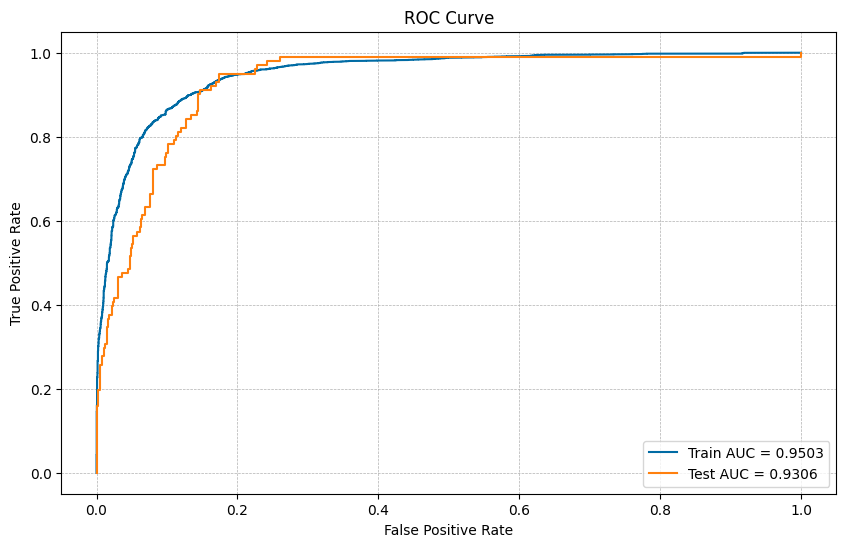

In [16]:
evaluator_lr.plot_roc()

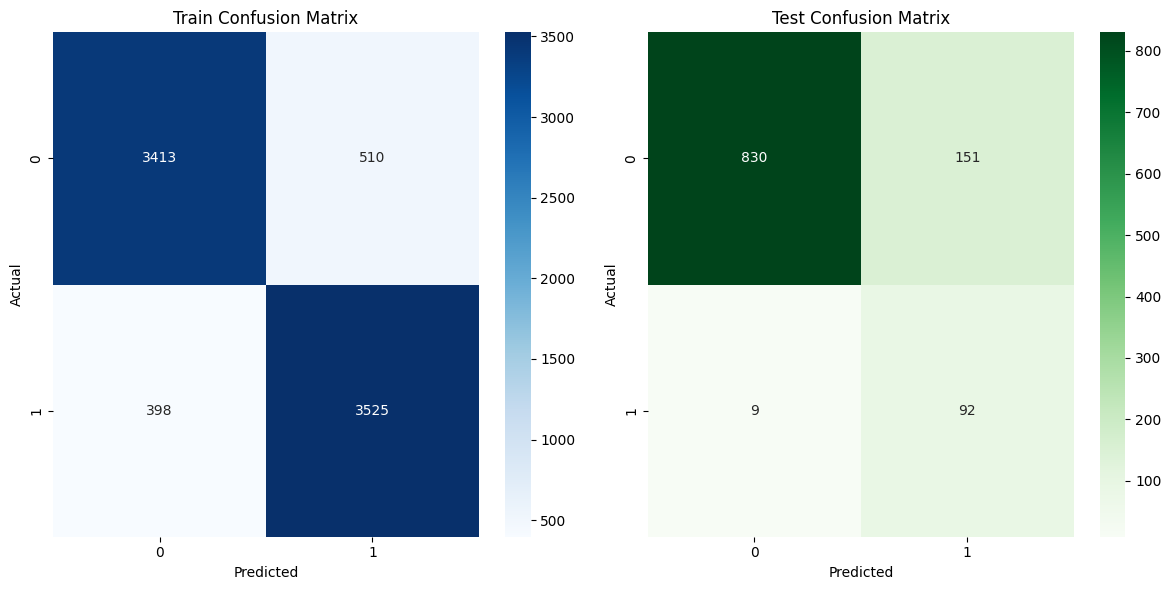

In [17]:
evaluator_lr.plot_confusion_matrices(y_train_ovsamp, y_test)

### Decision Tree

In [18]:
dt_model = DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_leaf=150,
                                  min_samples_split=150, random_state=49)
evaluator_dt = FraudModelEvaluator(dt_model)    
evaluator_dt.train(X_train_ovsamp, y_train_ovsamp)
evaluator_dt.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Best Threshold      : 0.6207
Train AUC           : 0.9481
Test AUC            : 0.9298
Train F1 Score      : 0.8828
Test F1 Score       : 0.5014


{'best_threshold': np.float64(0.6206896551724138),
 'train_auc': np.float64(0.9480582399048105),
 'test_auc': np.float64(0.9297847215914252),
 'train_f1': 0.8828467610575116,
 'test_f1': 0.5013774104683195}

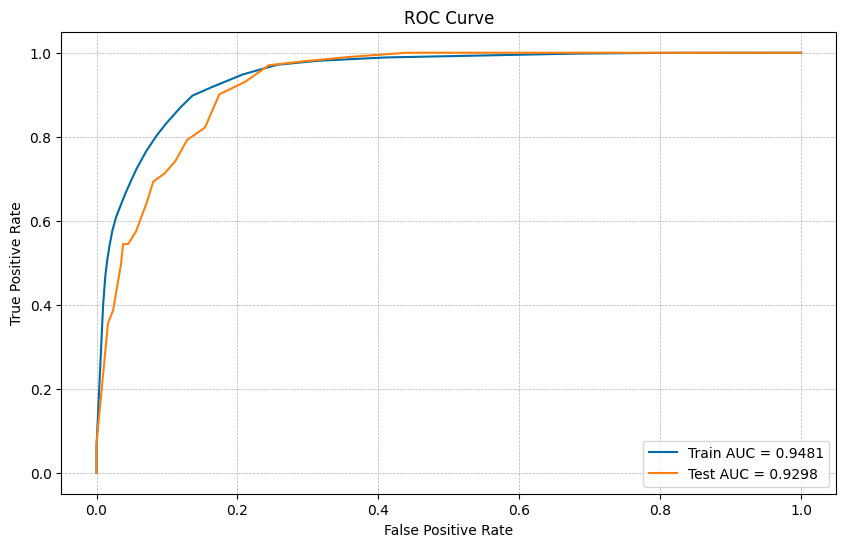

In [19]:
evaluator_dt.plot_roc()

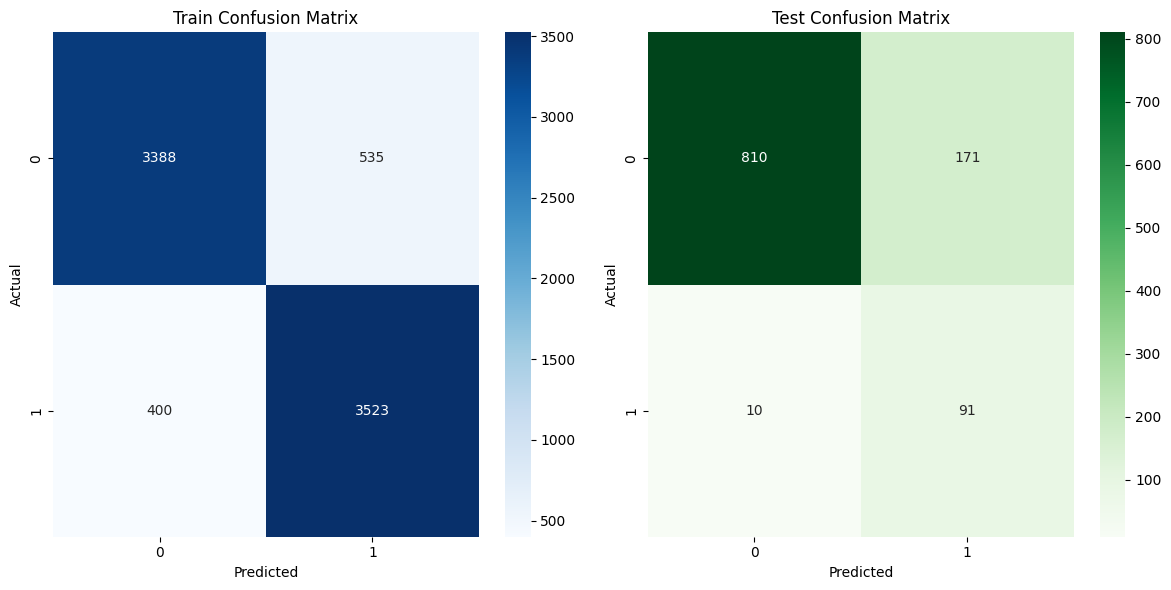

In [20]:
evaluator_dt.plot_confusion_matrices(y_train_ovsamp, y_test)

### Random Forest

In [21]:
rf_model = RandomForestClassifier(n_estimators=30, max_depth=4, min_samples_leaf=50,
                                  min_samples_split=50, random_state=49)
evaluator_rf = FraudModelEvaluator(rf_model)
evaluator_rf.train(X_train_ovsamp, y_train_ovsamp)    
evaluator_rf.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Best Threshold      : 0.5219
Train AUC           : 0.9539
Test AUC            : 0.9351
Train F1 Score      : 0.8957
Test F1 Score       : 0.5141


{'best_threshold': np.float64(0.521854135392707),
 'train_auc': np.float64(0.9538738287876443),
 'test_auc': np.float64(0.9351036021033295),
 'train_f1': 0.895674934563131,
 'test_f1': 0.5141242937853108}

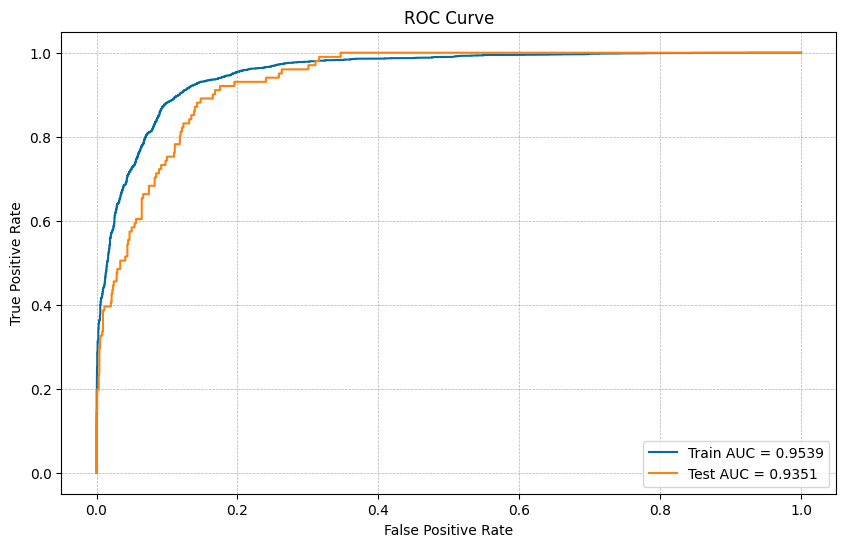

In [22]:
evaluator_rf.plot_roc()

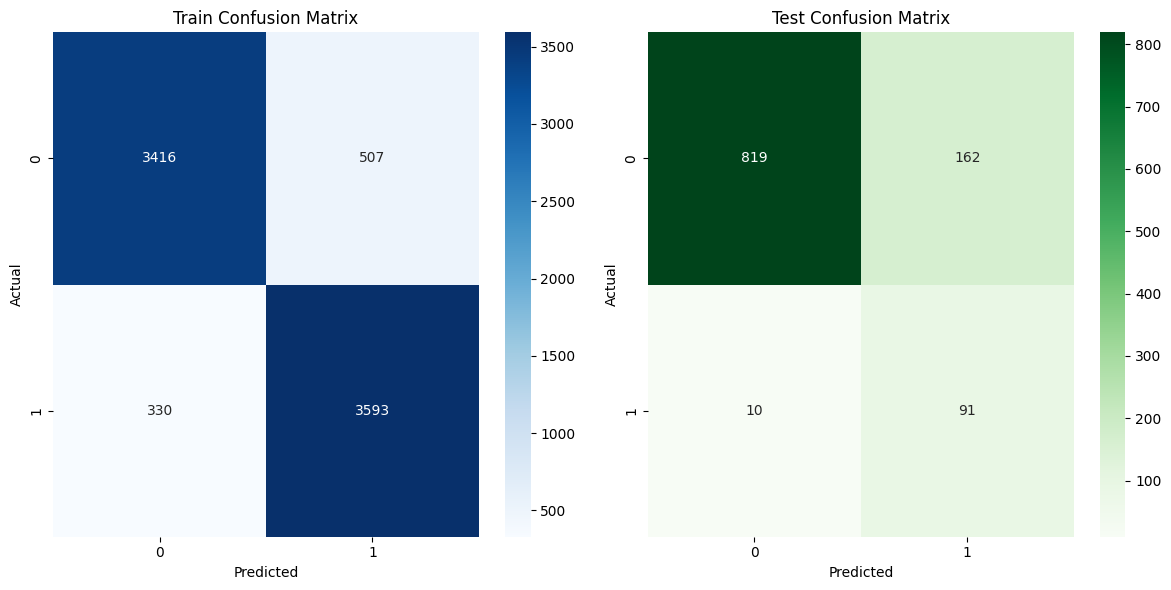

In [23]:
evaluator_rf.plot_confusion_matrices(y_train_ovsamp, y_test)   

In [24]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=49
)

In [25]:
evaluator_xgb = FraudModelEvaluator(model=xgb_model)
evaluator_xgb.train(X_train_ovsamp, y_train_ovsamp)

metrics_xgb = evaluator_xgb.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Best Threshold      : 0.6283
Train AUC           : 0.9956
Test AUC            : 0.9309
Train F1 Score      : 0.9676
Test F1 Score       : 0.5766


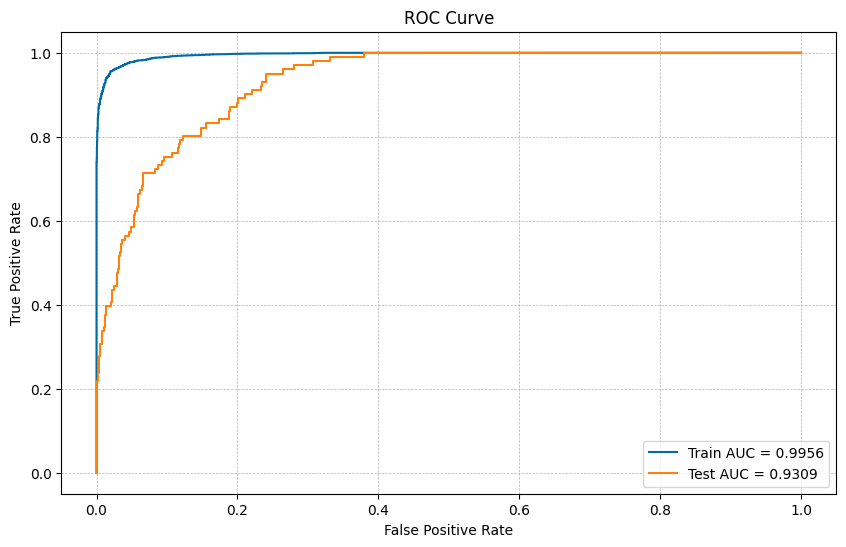

In [26]:
evaluator_xgb.plot_roc()

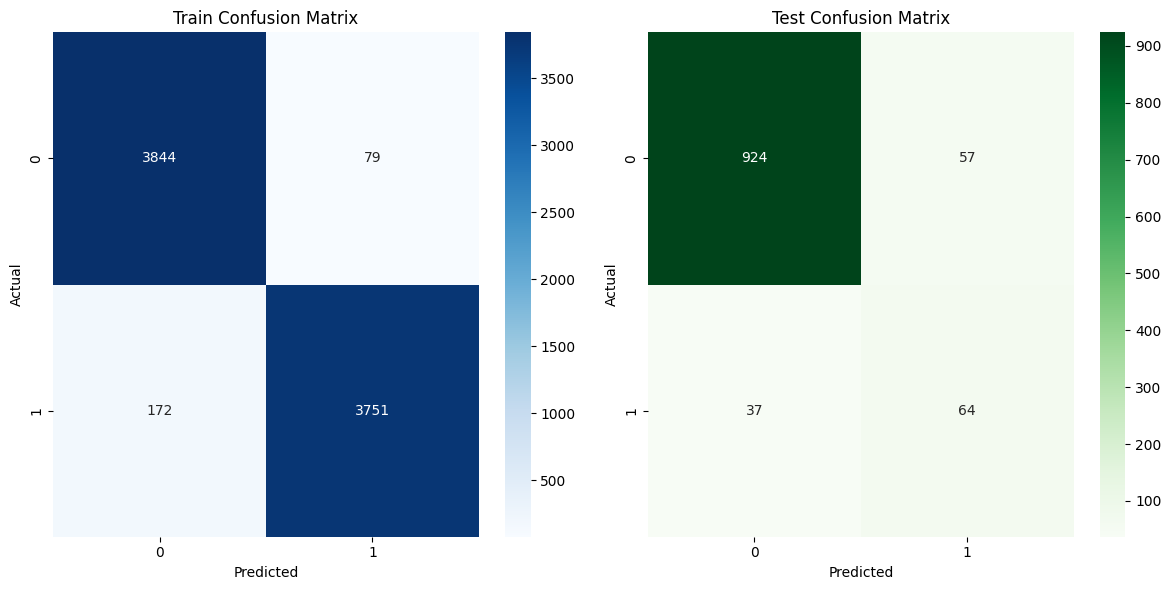

In [27]:
evaluator_xgb.plot_confusion_matrices(y_train_ovsamp, y_test)

In [28]:
X_sample = shap.sample(X_train_ovsamp, 500)

explainer = shap.Explainer(evaluator_xgb.model, X_sample)

shap_values = explainer(X_test_std)

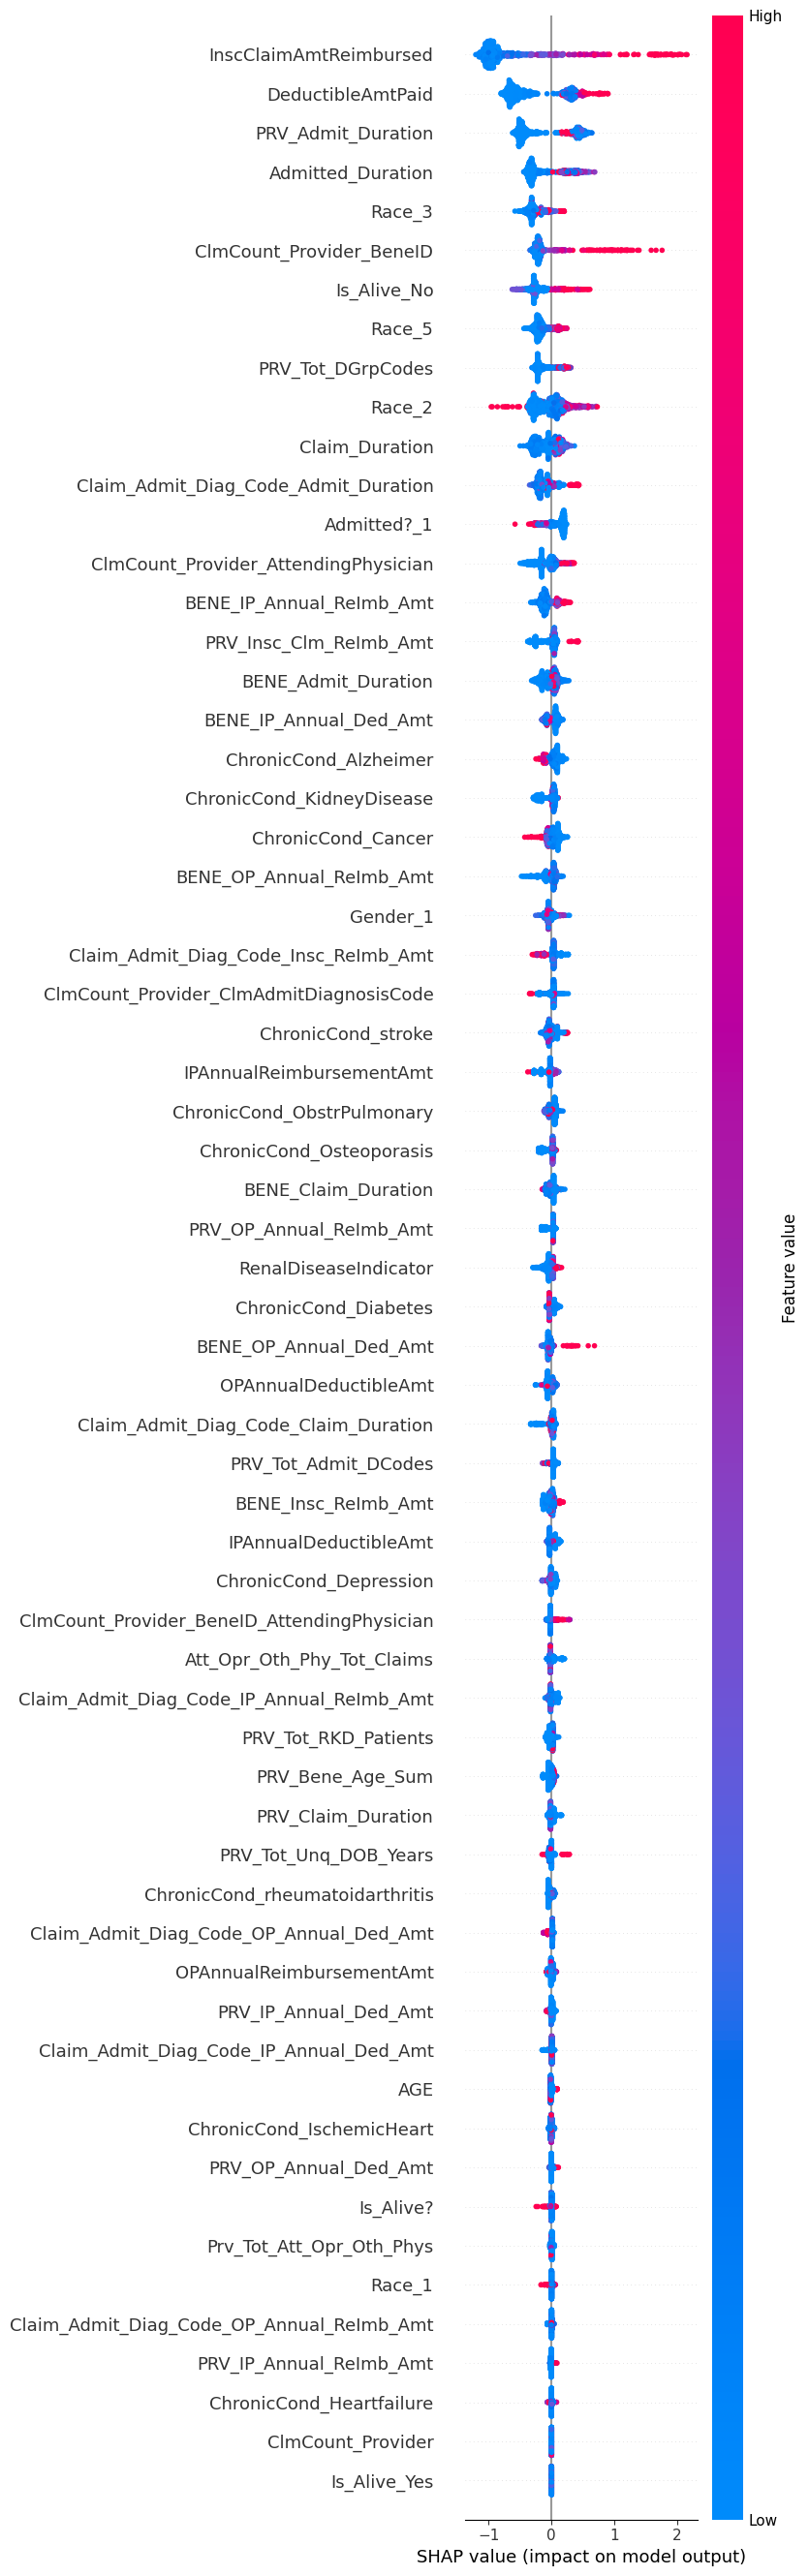

In [32]:
shap.summary_plot(shap_values, X_test_std, show=True, max_display=100)

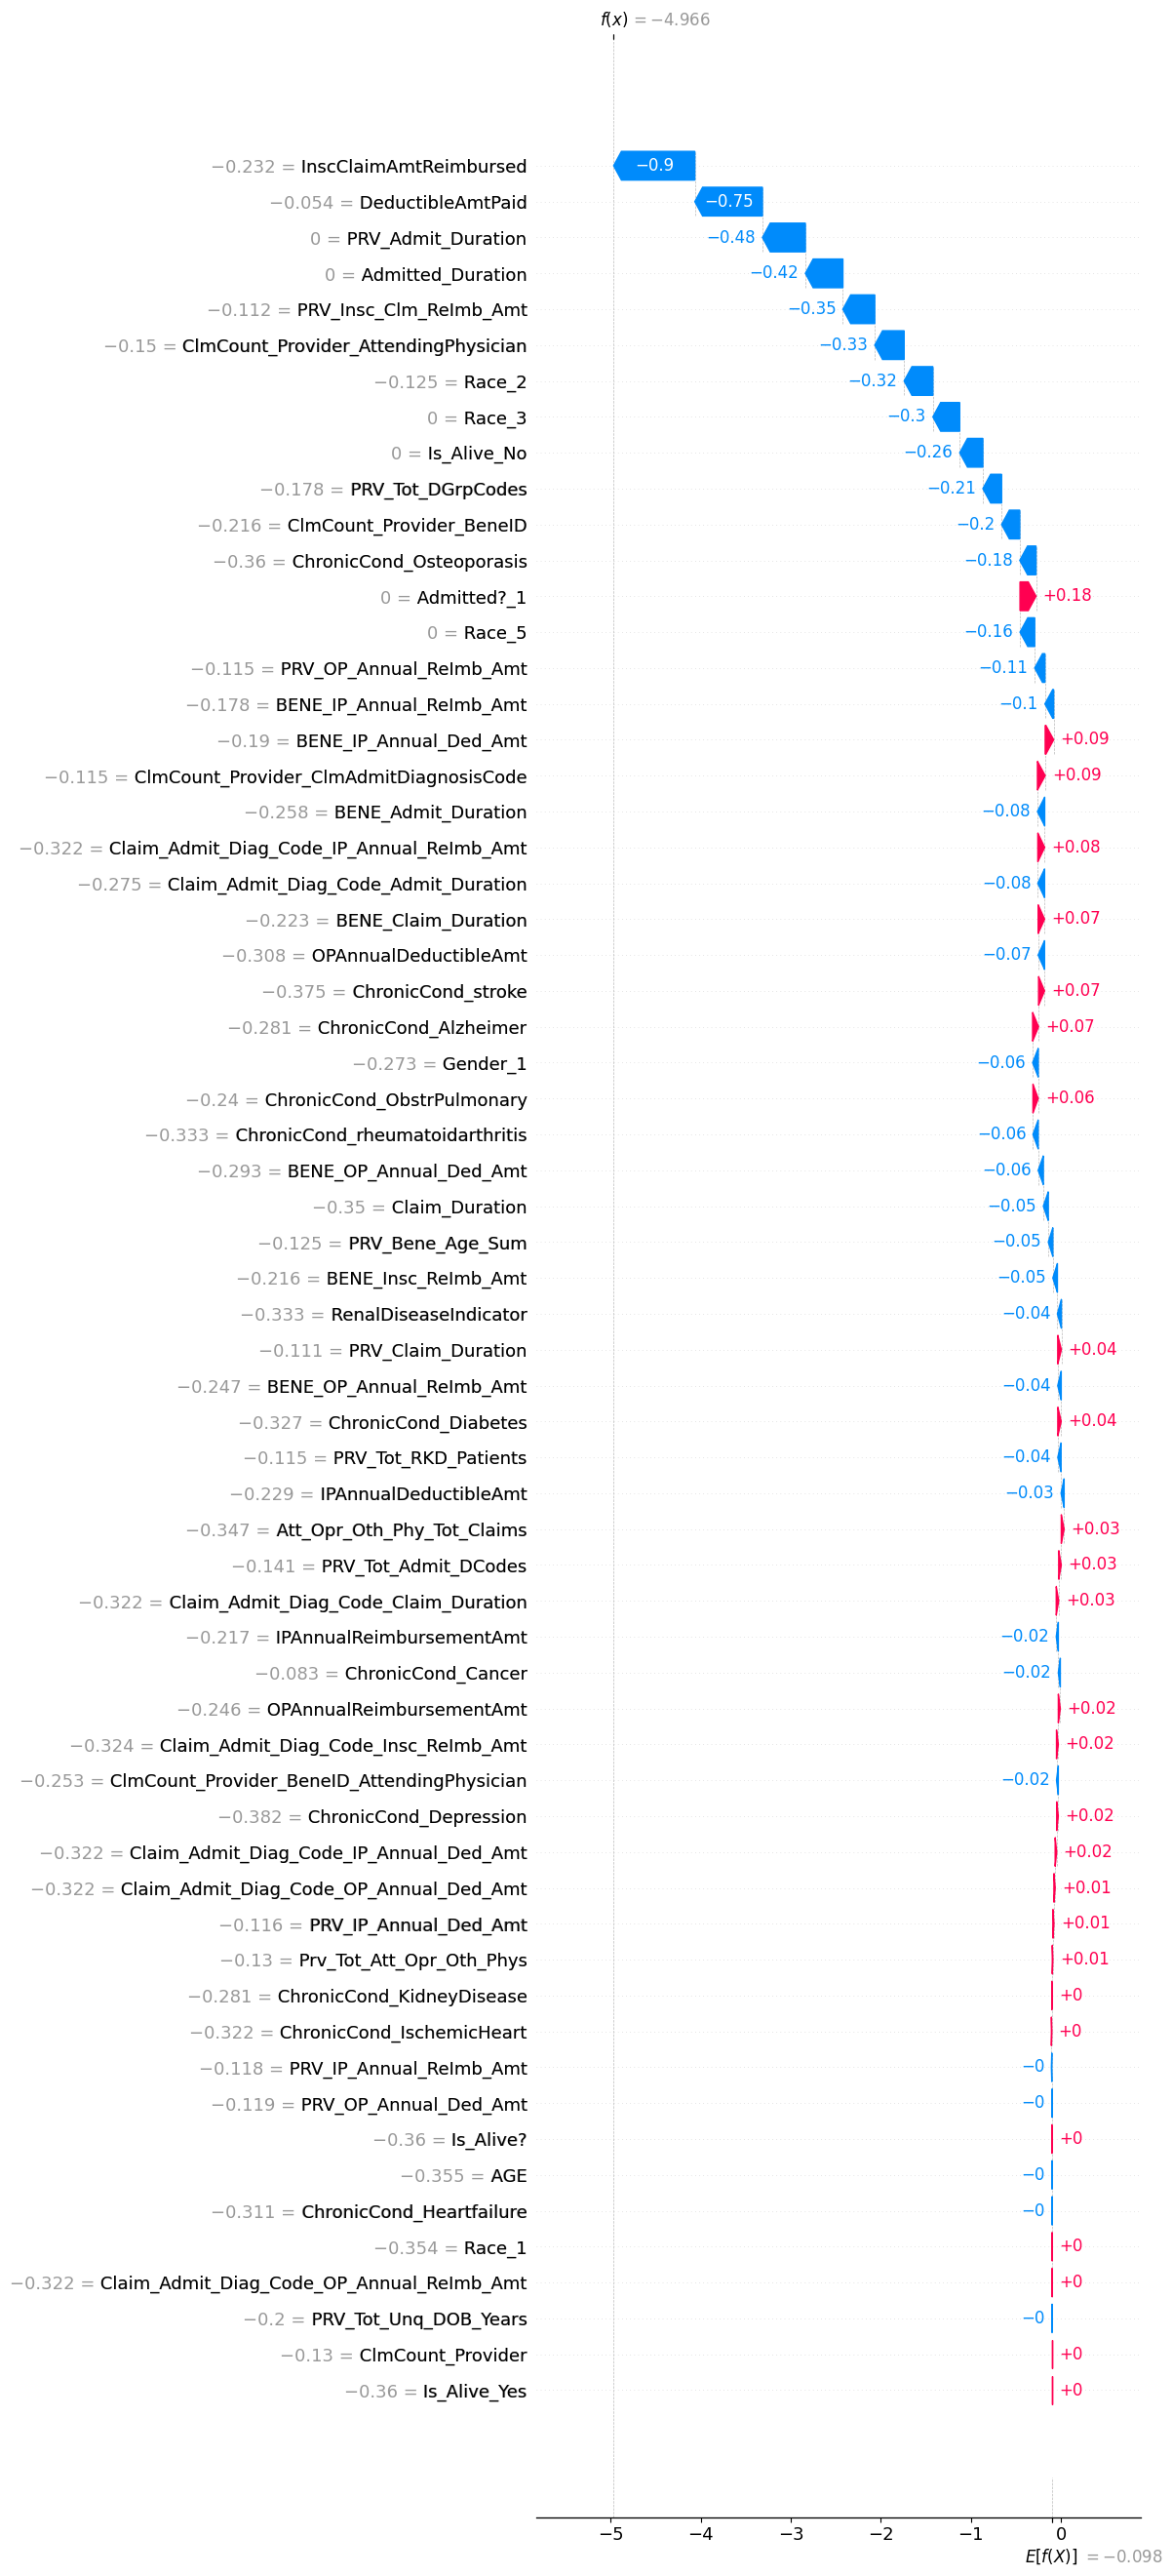

In [34]:
shap.plots.waterfall(shap_values[0], max_display=100)

In [35]:
shap_importance = pd.DataFrame({
    'feature': X_test_std.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print(shap_importance.head(10))

                     feature  importance
0     InscClaimAmtReimbursed    0.884854
1          DeductibleAmtPaid    0.498041
33        PRV_Admit_Duration    0.439163
19         Admitted_Duration    0.306330
58                    Race_3    0.270406
50  ClmCount_Provider_BeneID    0.256601
61               Is_Alive_No    0.249068
59                    Race_5    0.185646
24         PRV_Tot_DGrpCodes    0.184001
57                    Race_2    0.179469
